In [1]:


import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id


tree_max_depth = 8
num_factors = 10
batch_size = 10000
batch_iteration = 1
downsample_pseudobulk = True
downsample_size = 10

dl = DataSet(sample_in,sample_out)
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,batch_size)

print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/ad_gbm/ad_gbm
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/ad_gbm/ad_gbm


In [2]:
model = np.load(sample_out+'_10000_dcnmf.npz')

In [3]:
dl.mtx

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = ['gene_'+str(x) for x in range(len(dl.genes))]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = model['barcodes']

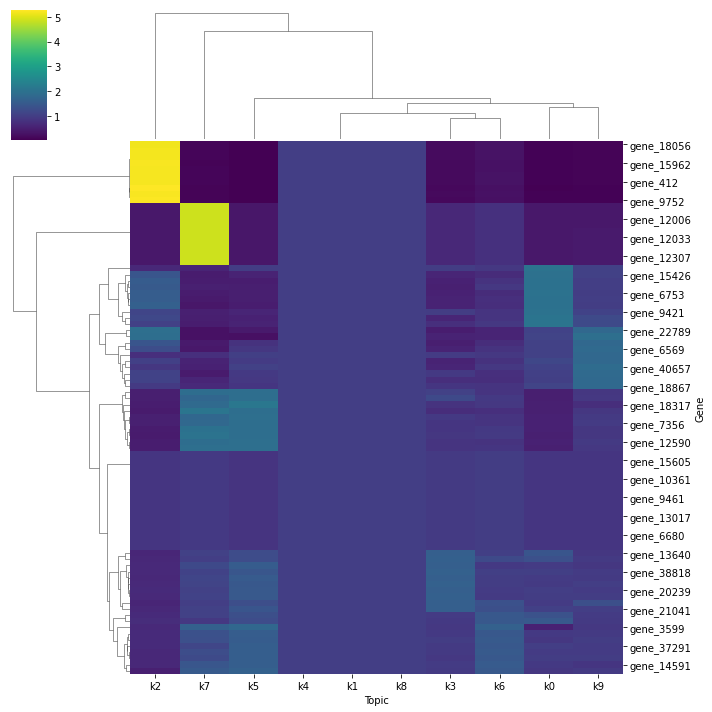

In [5]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = model['barcodes']
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACGGGAGATCCCGC_11409232@AD_AD,9,-8.725135,9.955455
1,AAAGATGCACGGTGTC_11409232@AD_AD,6,-1.117924,0.108030
2,AAATGCCTCCAATGGT_11409232@AD_AD,1,0.552396,-4.817207
3,AACCATGTCAGTGCAT_11409232@AD_AD,9,-5.680115,8.094940
4,AACCATGTCTGTACGA_11409232@AD_AD,0,7.209555,-0.538924
...,...,...,...,...
9994,CGTTGGGAGCGTCAAG_BT324-GSC_BT324-GSC@GBM_GBM,4,12.285528,2.848522
9995,CGTTGGGCAAAGAATC_BT324-GSC_BT324-GSC@GBM_GBM,6,9.121782,7.215079
9996,CGTTGGGCAGATCCAT_BT324-GSC_BT324-GSC@GBM_GBM,4,13.745404,7.874395
9997,CGTTGGGGTCTCTTTA_BT324-GSC_BT324-GSC@GBM_GBM,1,-0.913102,1.554419


Text(0, 0.5, 'UMAP2')

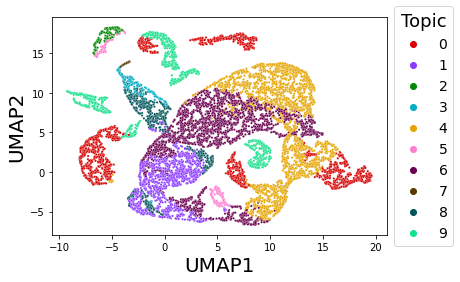

In [8]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

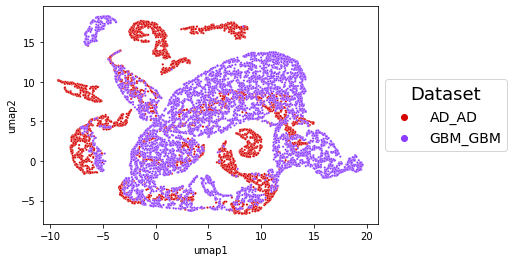

In [10]:
df_umap['batch'] = [x.split('@')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Dataset',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))